In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [7]:
import time, datetime, random, statistics, gc, re
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# 1. Preprocessing

In [5]:
def get_length_distribution(df):
    """
    Get statistics of the lengths of the articles in each newspaper.
    
    Parameters
    ----------
    df: Dataframe with the raw texts.
    """
    
    length = []
    for text in df['text']:
        length.append(len(text.split()))
        
    print(pd.Series(length).describe())

    plt.hist(length, bins = [i*100 for i in range(1, max(length)//100 + 2)])
    print("Average length of the texts:", statistics.mean(length))

In [6]:
def clean_text(text):
    text=re.sub("\W+"," ",text)

    return text

In [7]:
def get_split(text1):
    """
    Split each raw text into sequences with maximally 200 word long.
    
    Parameters
    ----------
    text1: A raw text.
    """
    
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [8]:
df_raw = pd.read_csv("../data/feature_statistics/document_level_statistics.tsv", sep="\t", encoding="utf-8")
df = df_raw.iloc[:, 1:3]
print(df.shape)
print(df["label"].value_counts())
df.head()

(23329, 2)
label
0    12107
1     6686
2     4536
Name: count, dtype: int64


,label,text
0,0,Die Berlinale ( 11. - 21. 2. ) wird in diesem ...
1,0,In Deutschland leben einem Bericht zufolge geg...
2,2,Baden-Württembergs grüner Ministerpräsident Wi...
3,1,Der Zuspruch zu einer Willkommenskultur Einw...
4,1,Über ihren Leitantrag zur Flüchtlingspolitik...


count    23329.000000
mean       348.857173
std        370.801158
min          3.000000
25%        103.000000
50%        213.000000
75%        467.000000
max       5037.000000
dtype: float64
Average length of the texts: 348.8571734750739


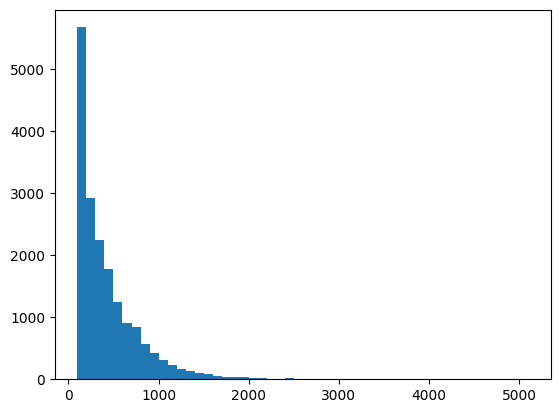

In [9]:
get_length_distribution(df)

count    12107.000000
mean       252.388288
std        304.275438
min          3.000000
25%         88.000000
50%        159.000000
75%        295.000000
max       5037.000000
dtype: float64
Average length of the texts: 252.3882877674073


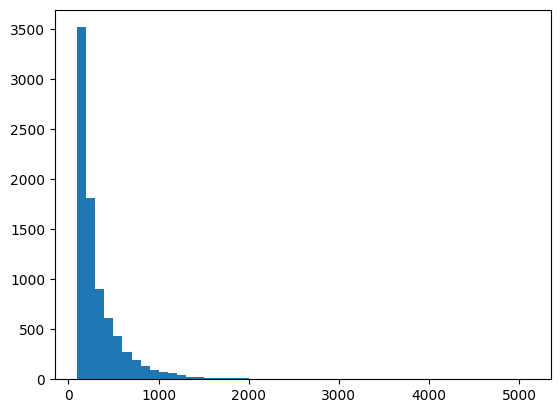

In [10]:
df_bild = df[df["label"]==0]
get_length_distribution(df_bild)

count    6686.000000
mean      497.649716
std       433.968172
min        11.000000
25%       182.000000
50%       377.000000
75%       688.750000
max      4299.000000
dtype: float64
Average length of the texts: 497.6497158241101


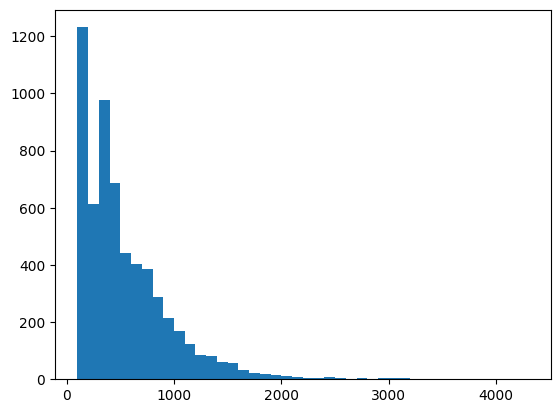

In [11]:
df_faz = df[df["label"]==1]
get_length_distribution(df_faz)

count    4536.000000
mean      387.023369
std       351.514552
min        17.000000
25%       111.000000
50%       276.000000
75%       555.250000
max      3180.000000
dtype: float64
Average length of the texts: 387.0233686067019


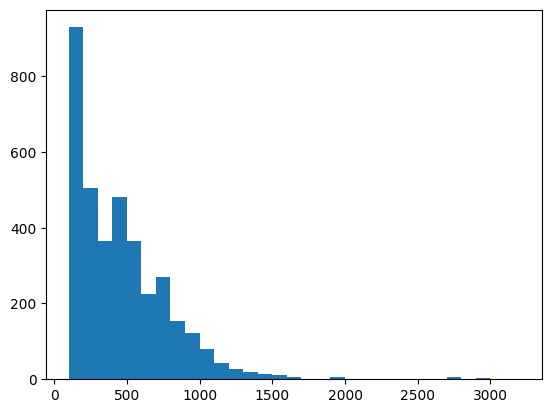

In [12]:
df_sz = df[df["label"]==2]
get_length_distribution(df_sz)

In [13]:
df['text'] = df["text"].apply(clean_text)
df.head()

,label,text
0,0,Die Berlinale 11 21 2 wird in diesem Jahr ihre...
1,0,In Deutschland leben einem Bericht zufolge geg...
2,2,Baden Württembergs grüner Ministerpräsident Wi...
3,1,Der Zuspruch zu einer Willkommenskultur Einwa...
4,1,Über ihren Leitantrag zur Flüchtlingspolitik ...


In [14]:
df['text_split'] = df["text"].apply(get_split)
df.head()

,label,text,text_split
0,0,Die Berlinale 11 21 2 wird in diesem Jahr ihre...,[Die Berlinale 11 21 2 wird in diesem Jahr ihr...
1,0,In Deutschland leben einem Bericht zufolge geg...,[In Deutschland leben einem Bericht zufolge ge...
2,2,Baden Württembergs grüner Ministerpräsident Wi...,[Baden Württembergs grüner Ministerpräsident W...
3,1,Der Zuspruch zu einer Willkommenskultur Einwa...,[Der Zuspruch zu einer Willkommenskultur Einwa...
4,1,Über ihren Leitantrag zur Flüchtlingspolitik ...,[Über ihren Leitantrag zur Flüchtlingspolitik ...


In [15]:
train_sequences = []
label_sequences = []

for idx, row in df.iterrows():
    for seq in row['text_split']:
        train_sequences.append(seq)
        label_sequences.append(row['label'])
        
df_sequences = pd.DataFrame({"sequence": train_sequences, "label": label_sequences})
print(df_sequences.shape)
print(df_sequences["label"].value_counts())
df_sequences.head()

(45317, 2)
label
0    18167
1    17581
2     9569
Name: count, dtype: int64


,sequence,label
0,Die Berlinale 11 21 2 wird in diesem Jahr ihre...,0
1,In Deutschland leben einem Bericht zufolge geg...,0
2,Baden Württembergs grüner Ministerpräsident Wi...,2
3,bei ihren Verhandlungen mit Kreisen und Kommun...,2
4,Der Zuspruch zu einer Willkommenskultur Einwan...,1


In [16]:
X = df_sequences["sequence"].values
y = df_sequences["label"].values

# 2. Fine-tuning BERT

## 2.1 Prepare data

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

In [18]:
test_max_len = 0

for text in X:
    input_ids = tokenizer.encode(text, 
                                 add_special_tokens=True)
    test_max_len = max(test_max_len, len(input_ids))

print('Max sentence length: ', test_max_len)

Max sentence length:  381


In [19]:
MAX_LEN = test_max_len
#MAX_LEN = 381
NUM_LABELS = 3
BATCH_SIZE = 16 
EPOCHS = 4

In [20]:
input_ids = []
attention_masks = []

for text in X:
    encoded_dict = tokenizer.encode_plus(
        text,                      
        add_special_tokens = True, 
        padding = "max_length",
        truncation = True,
        max_length = MAX_LEN,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
    # ----- Checking the results of tokenization -----
    #print(text)
    #print(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])) 
    #print(len(tokenizer.convert_ids_to_tokens(encoded_dict['input_ids'][0])))
    #print("-----") 
    
print("Done with tokenization.")

Done with tokenization.


In [21]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

In [22]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=RANDOM_STATE, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=RANDOM_STATE, test_size=0.2)

print("Shape of training and validation set:")
print(train_inputs.shape)
print(train_labels.shape)
print(validation_inputs.shape)
print(validation_labels.shape)

print("\nShape of attention masks:")
print(len(train_masks))
print(len(validation_masks))

Shape of training and validation set:
torch.Size([36253, 381])
torch.Size([36253])
torch.Size([9064, 381])
torch.Size([9064])

Shape of attention masks:
36253
9064


**Create DataLoader for training and validation set:**

In [23]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## 2.2. Fine-tuning

In [24]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", 
    num_labels = NUM_LABELS, 
    output_attentions = False, 
    output_hidden_states = True, 
)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,   
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [26]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
torch.cuda.empty_cache()

In [28]:
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test 
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        # PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,266.    Elapsed: 0:00:21.
  Batch    80  of  2,266.    Elapsed: 0:00:42.
  Batch   120  of  2,266.    Elapsed: 0:01:04.
  Batch   160  of  2,266.    Elapsed: 0:01:25.
  Batch   200  of  2,266.    Elapsed: 0:01:46.
  Batch   240  of  2,266.    Elapsed: 0:02:08.
  Batch   280  of  2,266.    Elapsed: 0:02:29.
  Batch   320  of  2,266.    Elapsed: 0:02:50.
  Batch   360  of  2,266.    Elapsed: 0:03:11.
  Batch   400  of  2,266.    Elapsed: 0:03:33.
  Batch   440  of  2,266.    Elapsed: 0:03:54.
  Batch   480  of  2,266.    Elapsed: 0:04:15.
  Batch   520  of  2,266.    Elapsed: 0:04:37.
  Batch   560  of  2,266.    Elapsed: 0:04:58.
  Batch   600  of  2,266.    Elapsed: 0:05:19.
  Batch   640  of  2,266.    Elapsed: 0:05:41.
  Batch   680  of  2,266.    Elapsed: 0:06:02.
  Batch   720  of  2,266.    Elapsed: 0:06:23.
  Batch   760  of  2,266.    Elapsed: 0:06:45.
  Batch   800  of  2,266.    Elapsed: 0:07:06.
  Batch   840  of

In [29]:
output_dir = './output/finetuned_BERT_on_200wordseqs'

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./output/finetuned_BERT_on_200wordseqs/tokenizer_config.json',
 './output/finetuned_BERT_on_200wordseqs/special_tokens_map.json',
 './output/finetuned_BERT_on_200wordseqs/vocab.txt',
 './output/finetuned_BERT_on_200wordseqs/added_tokens.json')